In [39]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

# import standard libs
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu'
# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import multiprocessing as mp
from multiprocessing import cpu_count 
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import pymc3 as pm
import numba as nb
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

import plotnine as pn

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 14,10
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook

import missingno as msno

import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0] # orrible, but runs
#nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from src.utils.utils import *
import src.features.bars as brs
import src.features.snippets as snp

import copyreg, types
copyreg.pickle(types.MethodType,snp._pickle_method,snp._unpickle_method)
RANDOM_STATE = 777

pdir = get_relative_project_dir('Adv_Fin_ML_Exercises')
data_dir = pdir/'data'/'processed'

print()
%watermark -p pandas,numpy,numba,pymc3,sklearn,statsmodels,scipy,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-10-27T16:15:55+02:00

CPython 3.6.6
IPython 7.0.1

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 0.23.4
numpy 1.15.3
numba 0.40.1
pymc3 3.5
sklearn 0.20.0
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.1
seaborn 0.9.0


# Pipeline
The goal is to produce a clean, easy to use, notebook which collects the main steps of the book
1. Import raw data
2. Sample data es. dollar value
3. Reduce overlappling (weighted sample)
4. Fractional differentiation
5. Feature importance analysis
6. Cross Validation (purged K-fold)

## 1. Import raw data

In [20]:
infp=Path(data_dir/'clean_IVE_fut_prices.parquet')
df = pd.read_parquet(infp)
#cprint(df)

infp=Path(data_dir/'IVE_dollarValue_resampled_1s.parquet')
if(not infp.exists()):
    dv_rs = dask_resample(df, '1s')
    cprint(dv_rs)
else:
    dv_rs = pd.read_parquet(infp)
    cprint(dv_rs)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask  size     v         dv
dates                                                             
2018-09-04 15:59:55  115.93  115.92  115.93   803   803   93091.79
2018-09-04 15:59:56  115.92  115.91  115.92   155   155   17967.60
2018-09-04 16:00:00  115.92  115.91  115.92  8570  8570  993434.40
2018-09-04 16:10:00  115.92  114.46  117.06     0     0       0.00
2018-09-04 18:30:00  115.92  115.35  116.57     0     0       0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1010793 entries, 2009-09-28 09:30:00 to 2018-09-04 18:30:00
Data columns (total 6 columns):
price    1010793 non-null float64
bid      1010793 non-null float64
ask      1010793 non-null float64
size     1010793 non-null int64
v        1010793 no

## 2. Sample data es. dollar value

In [44]:
dbars = brs.dollar_bar_df(dv_rs, 'dv', 1_000_000)
#cprint(dbars)

close = dbars.price.copy()
dailyVol = snp.getDailyVol(close)
#cprint(dailyVol)

tEvents = snp.getTEvents(close,h=dailyVol.mean())
print('######### tEvents ############')
cprint(tEvents)

t1 = snp.addVerticalBarrier(tEvents, close)
cprint(t1)

# select profit taking stoploss factor
ptsl = [1,1]
# target is dailyVol computed earlier
target=dailyVol
# select minRet
minRet = 0.005
# get cpu count - 1
cpus = cpu_count() - 1

events = snp.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
print('######### events ############')
cprint(events)

100%|██████████| 34417/34417 [00:03<00:00, 11222.98it/s]

######### tEvents ############
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                      0
2018-08-30 13:46:39 2018-08-30 13:46:39
2018-08-31 09:41:09 2018-08-31 09:41:09
2018-08-31 13:16:01 2018-08-31 13:16:01
2018-09-04 10:09:40 2018-09-04 10:09:40
2018-09-04 14:13:51 2018-09-04 14:13:51
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4949 entries, 2009-09-28 14:11:01 to 2018-09-04 14:13:51
Data columns (total 1 columns):
0    4949 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 77.3 KB
None
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
    


2018-10-27 16:18:43.077038 100.0% applyPtSlOnT1 done after 0.07 minutes. Remaining 0.0 minutes..


######### events ############
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1      trgt
2018-08-20 15:17:09 2018-08-21 15:24:47  0.006413
2018-08-21 14:20:43 2018-08-22 14:29:54  0.005533
2018-08-22 10:45:33 2018-08-23 11:19:28  0.005154
2018-08-23 09:58:29 2018-08-24 10:29:35  0.005252
2018-08-24 09:30:24 2018-08-27 09:33:40  0.005034
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4038 entries, 2009-09-30 10:03:45 to 2018-08-24 09:30:24
Data columns (total 2 columns):
t1      4038 non-null datetime64[ns]
trgt    4038 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 94.6 KB
None
-------------------------------------------------------------------------------



## 3. Reduce overlappling (weighted sample)

In [45]:
numCoEvents = snp.mpPandasObj(snp.mpNumCoEvents,('molecule',events.index),                         
                              cpus,closeIdx=close.index,t1=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()
out['tW'] = snp.mpPandasObj(snp.mpSampleTW,('molecule',events.index),
                            cpus,t1=events['t1'],numCoEvents=numCoEvents)
## example ##
out['w']=snp.mpPandasObj(snp.mpSampleW,('molecule',events.index),cpus,
                         t1=events['t1'],numCoEvents=numCoEvents,close=close)
out['w']*=out.shape[0]/out['w'].sum()
print('######### out ############')
cprint(out)

2018-10-27 16:18:46.186345 100.0% mpNumCoEvents done after 0.02 minutes. Remaining 0.0 minutes..
2018-10-27 16:18:47.131060 100.0% mpSampleTW done after 0.01 minutes. Remaining 0.0 minutes..


######### out ############
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           tW         w
2018-08-20 15:17:09  0.800000  1.248924
2018-08-21 14:20:43  0.690476  1.276677
2018-08-22 10:45:33  0.704545  0.932464
2018-08-23 09:58:29  0.815789  0.214951
2018-08-24 09:30:24  0.900000  2.104759
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4038 entries, 2009-09-30 10:03:45 to 2018-08-24 09:30:24
Data columns (total 2 columns):
tW    4038 non-null float64
w     4038 non-null float64
dtypes: float64(2)
memory usage: 94.6 KB
None
-------------------------------------------------------------------------------



2018-10-27 16:18:48.331636 100.0% mpSampleW done after 0.02 minutes. Remaining 0.0 minutes.


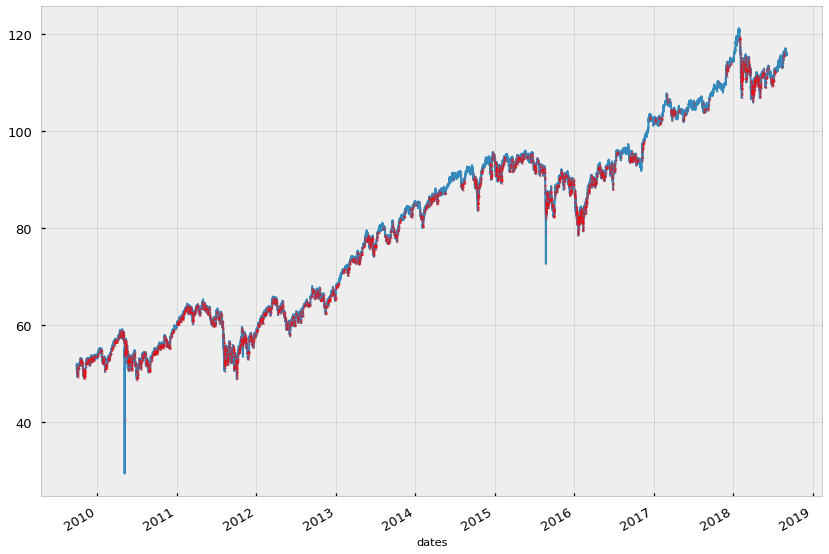

In [46]:
dv_rs.price.plot()
dv_rs.loc[out.index, 'price'].plot(ls='', marker='^', markersize=3, alpha=0.3, color='red')
#df.price.plot()
plt.show()

## 4. Fractional differentiation